In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [21]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [20]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Future Settle Prices'}, xlabel='Date'>

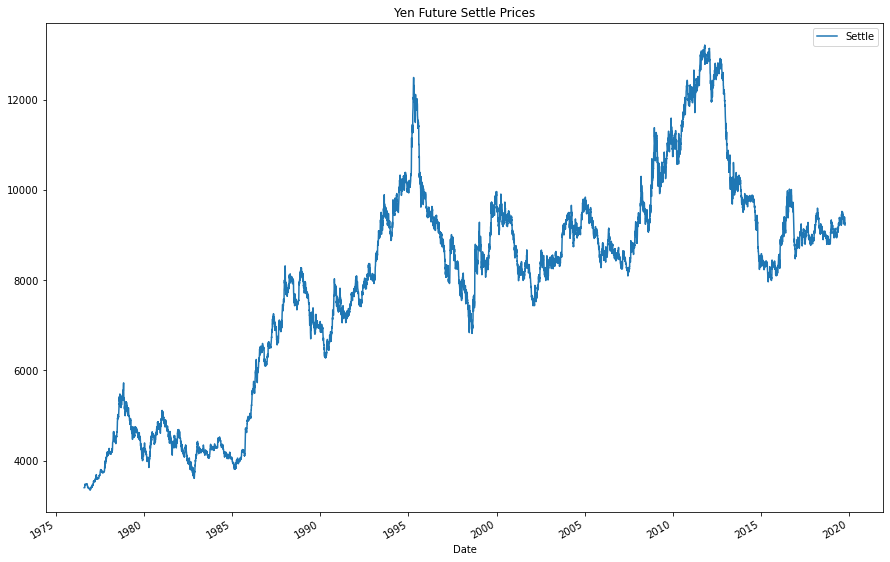

In [23]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures.Settle.plot(figsize=[15,10],title='Yen Future Settle Prices',legend=True)

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [29]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])



In [30]:
ts_trend.head

<bound method NDFrame.head of Date
1976-08-02    3390.825312
1976-08-03    3394.761444
1976-08-04    3398.703935
1976-08-05    3402.663044
1976-08-06    3406.650464
                 ...     
2019-10-09    9313.060753
2019-10-10    9309.368559
2019-10-11    9305.454594
2019-10-14    9301.423060
2019-10-15    9297.344123
Name: Settle_trend, Length: 10902, dtype: float64>

In [31]:
ts_noise.head()

Date
1976-08-02    10.174688
1976-08-03     6.238556
1976-08-04     2.296065
1976-08-05    -1.663044
1976-08-06    -5.650464
Name: Settle_cycle, dtype: float64

In [32]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!

df_yen_futures = yen_futures[['Settle']].copy()
df_yen_futures['trend'] = ts_trend
df_yen_futures['noise'] = ts_noise
df_yen_futures.tail()

,Settle,trend,noise
Date,,,
2019-10-09,9338.0,9313.060753,24.939247
2019-10-10,9303.5,9309.368559,-5.868559
2019-10-11,9251.0,9305.454594,-54.454594
2019-10-14,9265.0,9301.423060,-36.423060
2019-10-15,9221.5,9297.344123,-75.844123


<AxesSubplot:title={'center':'Settle vs Trend'}, xlabel='Date'>

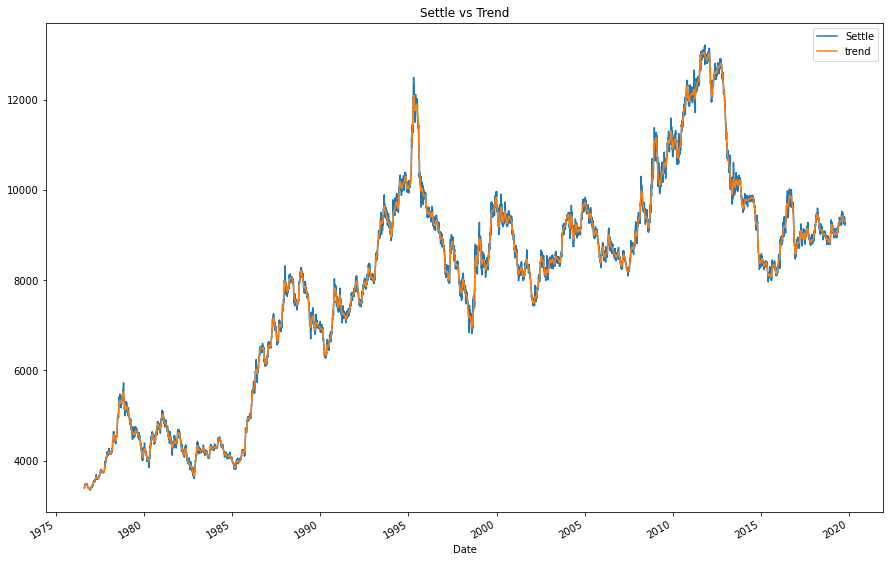

In [33]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
df_yen_futures.plot(y=['Settle', 'trend'],figsize=[15,10],title='Settle vs Trend',legend=True)

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

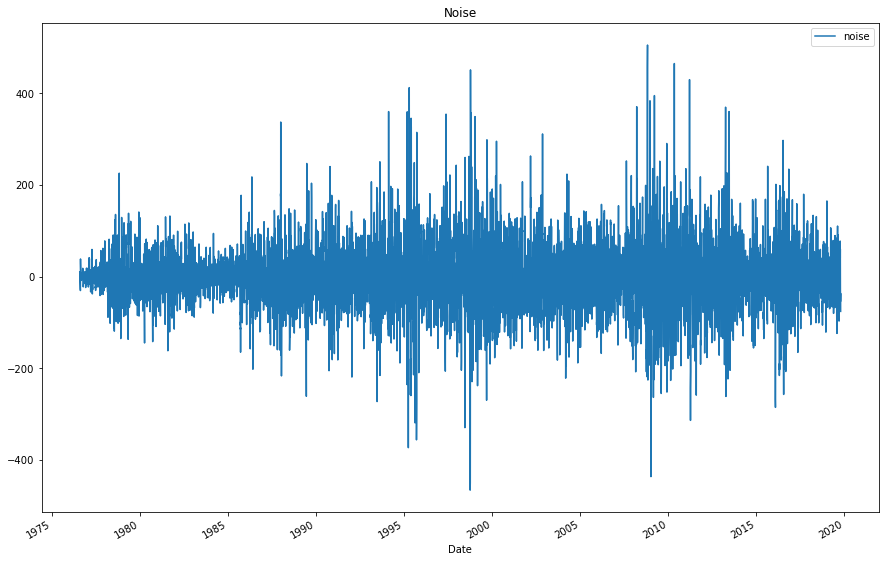

In [34]:
# Plot the Settle Noise
# YOUR CODE HERE!
df_yen_futures.plot(y='noise',figsize=[15,10],title='Noise',legend=True)

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [64]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [41]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!

model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
results = model.fit()

In [42]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10901
Model:                     ARMA(2, 1)   Log Likelihood              -11512.994
Method:                       css-mle   S.D. of innovations              0.696
Date:                Tue, 26 Oct 2021   AIC                          23035.987
Time:                        15:09:57   BIC                          23072.470
Sample:                             0   HQIC                         23048.284
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.007      1.748      0.080      -0.001       0.025
ar.L1.y       -0.6659      0.417     -1.598      0.110      -1.482       0.151
ar.L2.y       -0.0074      0.010     -0.770      0.441      -0.026       0.011
ma.L1.y        0.6610      0.417      1.587      0.113      -0.155       1.477
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5277           +0.0000j            1.5277            0.5000
AR.2          -88.7972           +0.0000j           88.7972            0.5000
MA.1           -1.5129           +0.0000j            1.5129            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

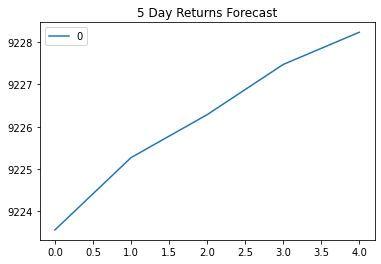

In [65]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [59]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

model = ARIMA(df_yen_futures['Settle'], order=(5,1,1))

# Fit the model
# YOUR CODE HERE!
results = model.fit()

C:\Users\arghy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\arghy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [60]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Tue, 26 Oct 2021   AIC                         119245.144
Time:                        15:37:07   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5346      0.526      1.017      0.309      -0.496       1.565
ar.L1.D.Settle     0.2262      0.595      0.380      0.704      -0.940       1.392
ar.L2.D.Settle    -0.0026      0.012     -0.223      0.824      -0.025       0.020
ar.L3.D.Settle    -0.0061      0.010     -0.594      0.553      -0.026       0.014
ar.L4.D.Settle    -0.0133      0.011     -1.244      0.214      -0.034       0.008
ar.L5.D.Settle    -0.0024      0.014     -0.178      0.859      -0.029       0.024
ma.L1.D.Settle    -0.2366      0.595     -0.398      0.691      -1.403       0.929
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9132           -1.4190j            2.3820           -0.1016
AR.2            1.9132           +1.4190j            2.3820            0.1016
AR.3           -1.7101           -3.0618j            3.5070           -0.3311
AR.4           -1.7101           +3.0618j            3.5070            0.3311
AR.5           -5.8772           -0.0000j            5.8772           -0.5000
MA.1            4.2264           +0.0000j            4.2264            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

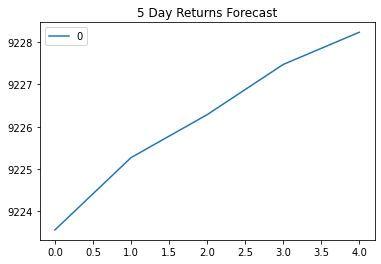

In [66]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [69]:
import arch 
from arch import arch_model

In [73]:
# Estimate a GARCH model:
# YOUR CODE HERE!
model= arch_model(returns['Settle'], mean = "Zero", vol="GARCH", p=2,q=1)

# Fit the model
# YOUR CODE HERE!
res = model.fit(disp="off")

In [74]:
# Summarize the model results
# YOUR CODE HERE!
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10917.0
Distribution:                  Normal   AIC:                           21842.0
Method:            Maximum Likelihood   BIC:                           21871.2
                                        No. Observations:                10901
Date:                Tue, Oct 26 2021   Df Residuals:                    10901
Time:                        15:47:08   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.6561e-03  3.286e-03      1.417      0.156 [-1.783e-03,1.110e-02]
alpha[1]       0.0404  1.388e-02      2.913  3.585e-03  [1.322e-02,6.763e-02]
alpha[2]       0.0000  2.164e-02      0.000      1.000 [-4.242e-02,4.242e-02]
beta[1]        0.9509  2.246e-02     42.340      0.000      [  0.907,  0.995]
=============================================================================

Covariance estimator: robust
"""

In [75]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [76]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts= res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

C:\Users\arghy\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [77]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.461055,7.507348,7.552962,7.597912,7.642213


In [78]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.461055
h.2,7.507348
h.3,7.552962
h.4,7.597912
h.5,7.642213


<AxesSubplot:title={'center':'5Day Forecast of Volatility'}>

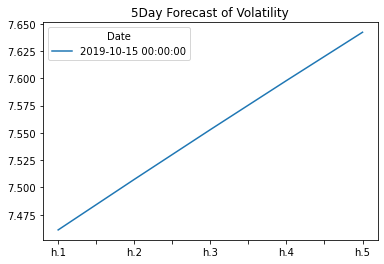

In [80]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title= '5Day Forecast of Volatility', legend= True)

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

In [81]:
print(f"Based on the time series analysis I would not buy the Yen now given the increased volatility.")

Based on the time series analysis I would not buy the Yen now given the increased volatility.


In [82]:
print(f"The risk of Yen is expected to Increase.")

The risk of Yen is expected to Increase.


In [83]:
print(f" Yes Based on the model evaluation I would feel confident is using the model for trading.")

 Yes Based on the model evaluation I would feel confident is using the model for trading.
